<a href="https://colab.research.google.com/github/gi1no/Education/blob/main/ThinkStats/chap13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

# Survival analysis

Survival analysis is a way to describe how long things last.
It is often used to study human lifetimes, but it also applies to "survival" of mechanical and electronic components, or more generally to an interval in time before any kind of event -- or even an interval in space.

We'll start with a simple example, the lifespans of light bulbs, and then consider a more substantial example, age at first marriage and how it has changed in the United States over the last 50 years.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap13.ipynb).

In [115]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [116]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Survival Functions

A fundamental concept in survival analysis is the **survival function**, which is the fraction of a population that survives longer than a given duration.
As a first example, we'll compute a survival function for the lifespans of light bulbs.

We'll use data from an experiment conducted in 2007.
Researchers installed 50 new light bulbs and left them on continuously.
They checked on the bulbs every 12 hours and recorded the lifespan of any that expired -- and ran the experiment until all 50 bulbs expired.
Instructions for downloading the data are in the notebook for this chapter.

The following cell downloads the data, which is documented [here](https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1).

Dataset from:
    
V.J. Menon and D.C. Agrawal,  Renewal Rate of Filament Lamps: Theory and Experiment. Journal of Failure Analysis and Prevention. December 2007, p. 421, Table 2/
DOI: 10.1007/s11668-007-9074-9

In [118]:
download(
    "https://gist.github.com/epogrebnyak/7933e16c0ad215742c4c104be4fbdeb1/raw/c932bc5b6aa6317770c4cbf43eb591511fec08f9/lamps.csv"
)

We can read the data like this.

In [119]:
df = pd.read_csv("lamps.csv", index_col=0)
df.tail()

,h,f,K
i,,,
28,1812,1,4
29,1836,1,3
30,1860,1,2
31,1980,1,1
32,2568,1,0


The `h` column contains lifespans in hours.
The `f` column records the number of bulbs that expired at each value of `h`.
To represent the distribution of lifespans, we'll put these values in a `Pmf` object and normalize it.

In [120]:
from empiricaldist import Pmf

pmf_bulblife = Pmf(df["f"].values, index=df["h"])
pmf_bulblife.normalize()

np.int64(50)

We can use `make_cdf` to compute the CDF, which indicates the fraction of bulbs that expire at or before each value of `h`.
For example, 78% of the bulbs expire at or before 1656 hours.

In [121]:
cdf_bulblife = pmf_bulblife.make_cdf()
cdf_bulblife[1656]

np.float64(0.7800000000000002)

The survival function is the fraction of bulbs that expire *after* each value of `h`, which is the complement of the CDF.
So we can compute it like this.

In [122]:
complementary_cdf = 1 - cdf_bulblife
complementary_cdf[1656]

np.float64(0.21999999999999975)

22% of the bulbs expired after 1656 hours.

The `empiricaldist` library provides a `Surv` object that represents a survival function, and a method called `make_surv` that makes one.

In [123]:
surv_bulblife = cdf_bulblife.make_surv()
surv_bulblife[1656]

np.float64(0.21999999999999997)

If we plot the CDF and the survival function, we can see that they are complementary -- that is, their sum is 1 at all values of `h`.

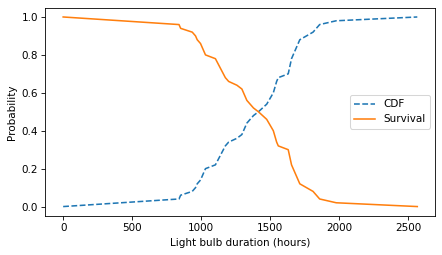

In [124]:
cdf_bulblife.plot(ls="--", label="CDF")
surv_bulblife.plot(label="Survival")

decorate(xlabel="Light bulb duration (hours)", ylabel="Probability")

In that sense, the CDF and survival function are equivalent -- if we are given either one, we can compute the other -- but in the context of survival analysis it is more common to work with survival curves.
And computing a survival curve is a step toward the next important concept, the hazard function.

## Hazard Function

In the light bulb dataset, each value of `h` represents a 12-hour interval ending at hour `h` -- which I will call "interval `h`".
Suppose we know that a light bulb has survived up to interval `h`, and we would like to know the probability that it expires during interval `h`.
To answer this question, we can use the survival function, which indicates the fraction of bulbs that survive past interval `h`, and the PMF, which indicates the fraction that expire during interval `h`.
The sum of these is the fraction of bulbs that *could* expire during interval `h`, which are said to be "at risk".
As an example, 26% of the bulbs were at risk during interval 1656.

In [125]:
at_risk = pmf_bulblife + surv_bulblife
at_risk[1656]

np.float64(0.25999999999999995)

And 4% of all bulbs expired during interval 1656.

In [126]:
pmf_bulblife[1656]

np.float64(0.04)

The **hazard** is the ratio of `pmf_bulblife` and `at_risk`.

In [127]:
hazard = pmf_bulblife / at_risk
hazard[1656]

np.float64(0.15384615384615388)

Of all bulbs that survived up to interval 1656, about 15% expired during interval 1656.

Instead of computing the hazard function ourselves, we can use `empiricaldist`, which provides a `Hazard` object that represents a hazard function, and a `make_hazard` method that computes it.

In [128]:
hazard_bulblife = surv_bulblife.make_hazard()
hazard_bulblife[1656]

np.float64(0.15384615384615397)

Here's what the hazard function looks like for the light bulbs.

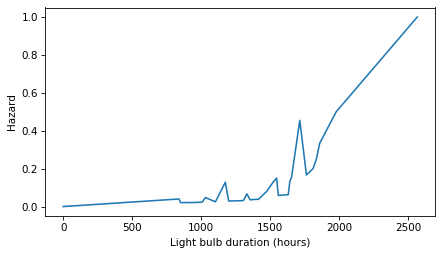

In [129]:
hazard_bulblife.plot()
decorate(xlabel="Light bulb duration (hours)", ylabel="Hazard")

We can see that the hazard is higher in some places than others, but this way of visualizing the hazard function can be misleading, especially in parts of the range where we don't have much data.
A better alternative is to plot the **cumulative hazard function**, which is the cumulative sum of the hazards.

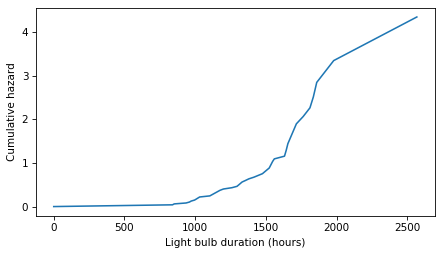

In [130]:
cumulative_hazard = hazard_bulblife.cumsum()
cumulative_hazard.plot()

decorate(xlabel="Light bulb duration (hours)", ylabel="Cumulative hazard")

Where the probability of expiring is high, the cumulative hazard function is steep.
Where the probability of expiring is low, the cumulative hazard function is flat.
In this example, we can see that the hazard is highest between 1500 and 2000 hours.
After that, the hazard decreases -- although this outcome is based on just one unusually long-lived bulb, so it might look different in another dataset.

Now that we have the general idea of survival and hazard functions, let's apply them to a more substantial dataset.

## Marriage Data

In many countries, people are getting married later than they used to, and more people stay unmarried.
To explore these trends in the United States, we'll use the tools of survival analysis and data from the National Survey of Family Growth (NSFG).

The NSFG dataset we used in previous chapters is the pregnancy file, which contains one row for each pregnancy reported by the survey respondents.
In this chapter, we'll work with the respondent file, which contains information about the respondents themselves.

I have compiled responses from nine iterations of the survey, conducted between 1982 and 2019, and selected data related to marriage.
Instructions for downloading this excerpt are in the notebook for this chapter.

The following cell downloads the data, which is a CSV file I created that combines data from several iterations of the NSFG survey, from 1982 to 2019.

Details of the data preparation are in [this notebook](https://github.com/AllenDowney/MarriageNSFG/blob/master/clean_nsfg.ipynb).

In [131]:
filename = "marriage_nsfg_female.csv.gz"
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/" + filename)

We can read the data like this.

In [132]:
resp = pd.read_csv("marriage_nsfg_female.csv.gz")
resp.shape

(70183, 34)

The excerpt includes one row for each of more than 70,000 respondents, and has the following variables related to age and marriage.

-   `cmbirth`: The respondent's date of birth, known for all respondents.

-   `cmintvw`: The date the respondent was interviewed, known for all respondents.

-   `cmmarrhx`: The date the respondent was first married, if applicable and known.

-   `evrmarry`: 1 if the respondent had been married prior to the date of interview, 0 otherwise.

The first three variables are encoded in "century-months" -- that is, the integer number of months since December 1899.
So century-month 1 is January 1900.

To explore generational changes, we'll group respondents by their decade of birth.
We'll use the following function, which takes a value of `cmbirth` and computes the corresponding decade of birth.
It uses the integer division operator `//` to divide by 10 and round down.

In [133]:
month0 = pd.to_datetime("1899-12-31")


def decade_of_birth(cmbirth):
    date = month0 + pd.DateOffset(months=cmbirth)
    return date.year // 10 * 10

We can use this function and the `apply` method to compute each respondent's decade of birth and assign it to a new column called `cohort`.
In this context, a **cohort** is a group of people with something in common -- like the decade they were born -- who are treated as a group for purposes of analysis.

The result from `value_counts` shows the number of people in each cohort.

In [134]:
from thinkstats import value_counts

resp["cohort"] = resp["cmbirth"].apply(decade_of_birth)
value_counts(resp["cohort"])

,count
cohort,
1930,325
1940,3608
1950,10631
1960,14953
1970,16438
1980,14271
1990,8552
2000,1405


The dataset includes more than 10,000 respondents born in each decade from the 1950s to the 1980s, and fewer respondents in the earlier and later decades.

Next we'll compute each respondent's age when married (if applicable) and their age when interviewed.

In [135]:
resp["agemarr"] = (resp["cmmarrhx"] - resp["cmbirth"]) / 12
resp["age"] = (resp["cmintvw"] - resp["cmbirth"]) / 12

To get started with this data, we'll use the following function, which takes as arguments a `DataFrame` and a list of cohorts, and returns a dictionary that maps from each cohort to a `Surv` object.
For each cohort, it selects their ages at first marriage and uses `Surv.from_seq` to compute a survival function.
The `dropna=False` argument includes `NaN` values in the survival function, so the result includes people who have not married.

In [136]:
from empiricaldist import Surv


def make_survival_map(resp, cohorts):
    surv_map = {}

    grouped = resp.groupby("cohort")
    for cohort in cohorts:
        group = grouped.get_group(cohort)
        surv_map[cohort] = Surv.from_seq(group["agemarr"], dropna=False)

    return surv_map

Here's how we use this function.

In [137]:
cohorts = [1980, 1960, 1940]
surv_map = make_survival_map(resp, cohorts)

And here are the results for people born in the 1940s, 1960s, and 1980s.

In [138]:
import matplotlib.pyplot as plt
import cycler

# Extract the default color cycle
default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Define the desired line styles
linestyles = ["--", "-", "-.", "--", "-", "-.", "--", "-", "-.", "--"]

# Ensure we cycle through styles and colors properly
custom_cycler = cycler.cycler(color=default_colors) + cycler.cycler(
    linestyle=linestyles
)

# Apply the new cycler
plt.rc("axes", prop_cycle=custom_cycler)

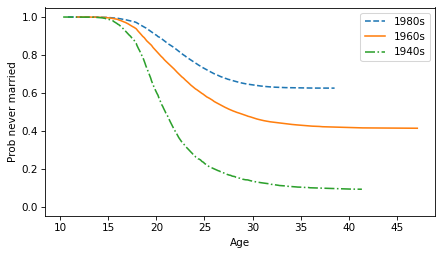

In [139]:
for cohort, surv in surv_map.items():
    surv.plot(label=f"{cohort}s")

ylim = [-0.05, 1.05]
decorate(xlabel="Age", ylabel="Prob never married", ylim=ylim)

If we take these results at face value, they show that people in earlier generations got married younger, and more of them got married eventually.
However, we should not interpret these results yet, because they are not correct.
There are two problems we have to address:

* As discussed in [Chapter 1](section_nsfg), the NSFG uses stratified sampling, which means that it deliberately oversamples some groups.

* Also, this way of computing the survival function does not properly take into account people who are not married yet.

For the first problem, we'll use a kind of resampling called a **weighted bootstrap**.
For the second problem, we'll use a method called Kaplan-Meier estimation.
We'll start with resampling.

## Weighted Bootstrap

The NSFG dataset includes a column called `finalwgt` that contains each respondent's sampling weight, which is the number of people in the population they represent.
We can use these weights during the resampling process to correct for stratified sampling.
The following function takes a `DataFrame` and the name of the column that contains the sampling weights.
It resamples the rows of the `DataFrame`, taking the sampling weights into account, and returns a new `DataFrame`.

In [140]:
def resample_rows_weighted(df, column="finalwgt"):
    n = len(df)
    weights = df[column]
    return df.sample(n, weights=weights, replace=True)

The current dataset includes respondents from several iterations of the survey, called cycles, so in order to resample, we have to group the respondents by cycle, resample each group, and then put the groups back together.
That's what the following function does.

In [141]:
def resample_cycles(resp):
    grouped = resp.groupby("cycle")
    samples = [resample_rows_weighted(group) for _, group in grouped]
    return pd.concat(samples)

To get started, we'll resample the data once.

In [142]:
# Seed the random number generator so we get the same results every time
np.random.seed(1)

In [143]:
sample = resample_cycles(resp)

Later we'll resample the data several times, so we can see how much variation there is due to random sampling.

The following figure shows the results with resampling, compared to the results from the previous section without resampling, shown as dotted lines.

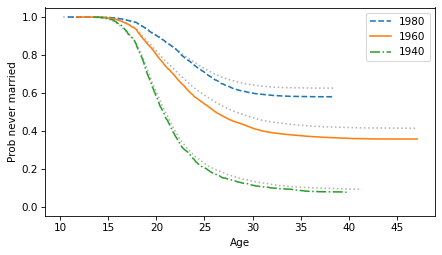

In [144]:
for label, surv in surv_map.items():
    surv.plot(ls=":", color="gray", alpha=0.6)

survs_resampled = make_survival_map(sample, cohorts)

for label, surv in survs_resampled.items():
    surv.plot(label=label)

decorate(xlabel="Age", ylabel="Prob never married", ylim=ylim)

In [145]:
plt.rc("axes", prop_cycle=plt.rcParamsDefault["axes.prop_cycle"])

The difference, with and without resampling, is substantial, which shows that we need to correct for stratified sampling to get accurate results.

Now let's get to the second problem, dealing with incomplete data.

## Estimating Hazard Functions

In the light bulb example, we know the life spans for all 50 bulbs, so we can compute the survival function directly -- and we can use the survival function to compute the hazard function.

In the marriage example, we know the age at first marriage for some respondents, the ones who had been married before they were interviewed.
But for respondents who had never married, we don't know at what age they would marry in the future -- or if they will.

This kind of missing data is said to be **censored**.
That term might seem odd, because censored information is usually hidden deliberately, but in this case it is hidden just because we don't know the future.

However, we have partial information we can work with: if someone is unmarried when they are surveyed, we know that the age when they get married (if they do) must be greater than their current age.

We can use this partial information to estimate the hazard function; then we can use the hazard function to compute the survival function.
This process is called **Kaplan-Meier estimation**.

To demonstrate, I'll select just one cohort from the resampled data.

In [146]:
resp60 = sample.query("cohort == 1960")

For respondents who were married when they were surveyed, we'll select their age at first marriage.
There are 9921 of them, which we'll call "complete" cases.

In [147]:
complete = resp60.query("evrmarry == 1")["agemarr"]
complete.count()

np.int64(9921)

For respondents who had not married, we'll select their age when they were surveyed.
There are 5468 of them, which we'll call the "ongoing" cases.

In [148]:
ongoing = resp60.query("evrmarry == 0")["age"]
ongoing.count()

np.int64(5468)

Now, to estimate the hazard function, we'll compute the total number of cases that were "at risk" at each age, including everyone who was unmarried up to that age.
It will be convenient to make a `FreqTab` object that counts the number of complete and ongoing cases at each age.

In [149]:
from empiricaldist import FreqTab

ft_complete = FreqTab.from_seq(complete)
ft_ongoing = FreqTab.from_seq(ongoing)

As an example, there are 58 respondents who reported that they were married for the first time at age 25.

In [150]:
ft_complete[25]

np.int64(58)

And another 5 respondents who were surveyed at age 25 and reported that they had never married.

In [151]:
ft_ongoing[25]

np.int64(5)

From these `FreqTab` objects, we can compute unnormalized `Surv` objects that contain the number of complete and ongoing cases that exceed each age.

In [152]:
surv_complete = ft_complete.make_surv()
surv_ongoing = ft_ongoing.make_surv()

For example, there are 2848 people who reported getting married after age 25.

In [153]:
surv_complete[25]

np.int64(2848)

And 2273 people surveyed after age 25 who had never married.

In [154]:
surv_ongoing[25]

np.int64(2273)

The sum of the four numbers we just computed is the number of respondents who were at risk -- that is, people who could have married at age 25.
The term "at risk" is a legacy of survival analysis in medicine, where it often refers to risk of disease or death.
It might seem incongruent in the context of marriage, which is generally considered a positive milestone.
That said, here's how we compute it.

In [155]:
at_risk = ft_complete[25] + ft_ongoing[25] + surv_complete[25] + surv_ongoing[25]
at_risk

np.int64(5184)

Of those, the number who actually married at age 25 is `ft_complete[25]`.
So we can compute the hazard function at age 25 like this.

In [156]:
hazard = ft_complete[25] / at_risk
hazard

np.float64(0.011188271604938271)

That's how we can compute the hazard function at a single age.
Now let's compute the whole function, for all ages.
We'll use the `union` method of the `Index` class to compute a Pandas `Index` that contains all of the ages from `ft_complete` and `ft_ongoing`, in order.

In [157]:
ts = pd.Index.union(ft_complete.index, ft_ongoing.index)

Now we can compute the number of people at risk at every age, by looking up the ages in `ts` in each of the  `FreqTab` and `Surv` objects.

In [158]:
at_risk = ft_complete(ts) + ft_ongoing(ts) + surv_complete(ts) + surv_ongoing(ts)

Finally, we can compute the hazard function at each age, and put the results into a `Hazard` object.

In [159]:
from empiricaldist import Hazard

hs = ft_complete(ts) / at_risk
hazard = Hazard(hs, ts)

Here's what the cumulative hazard function looks like.

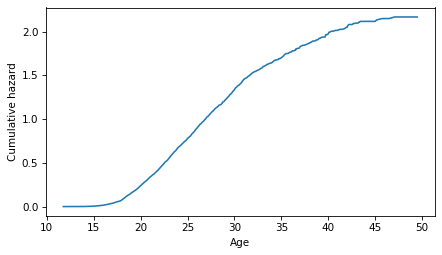

In [160]:
hazard.cumsum().plot()

decorate(xlabel="Age", ylabel="Cumulative hazard")

It is steepest between ages 20 and 30, which means that an unmarried person is at the greatest "risk" of getting married at these ages.
After that, the cumulative hazard levels off, which means that the hazard gradually decreases.

## Estimating Survival Functions

If we are given a survival function, we know how to compute the hazard function.
Now let's go in the other direction.

Here's one way to think of it.
The hazard function indicates the probability of getting married at each age, if you have not already married.
So the complement of the hazard function is the probability of staying unmarried at each age.

In order to "survive" past a given age, `t`, you have to stay unmarried at every age up to and including `t`.
And the probability of doing that is the product of the complementary hazard function, which we can compute like this.

In [161]:
ps = (1 - hazard).cumprod()

The `Hazard` object has a `make_surv` method that does this computation.

In [162]:
surv = hazard.make_surv()

Here's what the result looks like, compared to the previous result (dotted line), which corrected for stratified resampling, but did not handle censored data.

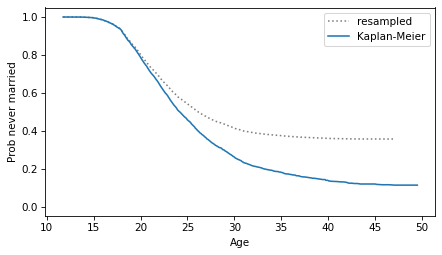

In [163]:
survs_resampled[1960].plot(ls=":", color="gray", label="resampled")
surv.plot(label="Kaplan-Meier")

decorate(xlabel="Age", ylabel="Prob never married", ylim=ylim)

We can see how important it is to handle censored data correctly.

A survival function like this was the basis of a famous magazine article in 1986 -- *Newsweek* reported that a 40-year old unmarried woman was "more likely to be killed by a terrorist" than get married.
That claim was widely reported and became part of popular culture, but it was wrong then (because it was based on faulty analysis) and turned out to be even more wrong (because of cultural changes that were already in progress).
In 2006, *Newsweek* ran an another article acknowledging their error.

I encourage you to read more about this article, the statistics it was based on, and the reaction.
It should remind you of the ethical obligation to perform statistical analysis with care, interpret the results with appropriate skepticism, and present them to the public accurately and honestly.

[Snopes has a good article on the topic](https://www.snopes.com/fact-check/marry-go-round/).

The following function encapsulates the steps of Kaplan-Meier estimation.
It takes as arguments sequences of survival times for complete and ongoing cases, and returns a `Hazard` object.

In [164]:
def estimate_hazard(complete, ongoing):
    """Kaplan-Meier estimation."""
    ft_complete = FreqTab.from_seq(complete)
    ft_ongoing = FreqTab.from_seq(ongoing)

    surv_complete = ft_complete.make_surv()
    surv_ongoing = ft_ongoing.make_surv()

    ts = pd.Index.union(ft_complete.index, ft_ongoing.index)
    at_risk = ft_complete(ts) + ft_ongoing(ts) + surv_complete(ts) + surv_ongoing(ts)

    hs = ft_complete(ts) / at_risk
    return Hazard(hs, ts)

And here's a function that takes a group of respondents, extracts survival times, calls `estimate_hazard` to get the hazard function, and then computes the corresponding survival function.

In [165]:
def estimate_survival(group):
    """Estimate the survival function."""
    complete = group.query("evrmarry == 1")["agemarr"]
    ongoing = group.query("evrmarry == 0")["age"]
    hf = estimate_hazard(complete, ongoing)
    sf = hf.make_surv()
    return sf

Soon we'll use these functions to compute confidence intervals for survival functions.
But first let's see another way to compute Kaplan-Meier estimates.

## Lifelines

A Python package called `lifelines` provides tools for survival analysis, including functions that compute Kaplan-Meier estimates.

The following cell installs `lifelines` if necessary.

In [166]:
try:
    import lifelines
except ImportError:
    %pip install lifelines

We can use it to confirm that the result in the previous section is correct.
First we'll compute the survival function using `estimate_survival`.

In [167]:
surv = estimate_survival(resp60)

Next we'll compute it using `lifelines`.
First we'll get the data into the format `lifelines` requires.

In [168]:
complete = complete.dropna()
durations = np.concatenate([complete, ongoing])
event_observed = np.concatenate([np.ones(len(complete)), np.zeros(len(ongoing))])

Now we can make a `KaplanMeierFitter` object and fit the data.

In [169]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(durations=durations, event_observed=event_observed)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 15389 total observations, 5468 right-censored observations>

After fitting the data, we can call the `plot` function to display the results, which include the estimated survival function and a confidence interval -- although the confidence interval is not correct in this case because it doesn't correct for stratified sampling.

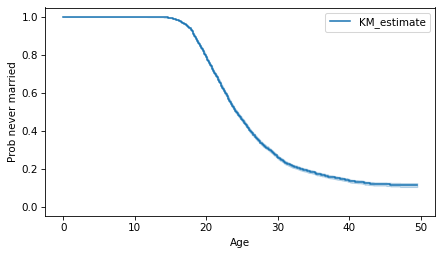

In [170]:
kmf.plot()

decorate(xlabel="Age", ylabel="Prob never married", ylim=ylim)

Unlike the survival function we computed, the one from `lifelines` starts from 0.
But the rest of the function is the same, within floating-point error.

In [171]:
ps = kmf.survival_function_["KM_estimate"].drop(0)
np.allclose(ps, surv)

True

In the next section, we'll use weighted resampling to compute confidence intervals that take stratified sampling into account.

## Confidence Intervals

The Kaplan-Meier estimate we computed is based on a single resampling of the dataset.
To get an idea of how much variation there is due to random sampling, we'll run the analysis with several resamplings and plot the results.

We'll use the following function, which takes a `DataFrame` and a list of cohorts, estimates the survival function for each cohort, and returns a dictionary that maps from each integer cohort to a `Surv` object.

This function is identical to `make_survival_map`, except that it calls `estimate_survival`, which uses Kaplan-Meier estimation, rather than `Surv.from_seq`, which only works if there is no censored data.

In [172]:
def estimate_survival_map(resp, cohorts):
    """Make a dictionary from cohorts to Surv objects."""
    surv_map = {}

    grouped = resp.groupby("cohort")
    for cohort in cohorts:
        group = grouped.get_group(cohort)
        surv_map[cohort] = estimate_survival(group)

    return surv_map

The following loop generates 101 random resamplings of the dataset and makes a list of 101 dictionaries containing the estimated survival functions.

In [173]:
cohorts = [1940, 1950, 1960, 1970, 1980, 1990]

surv_maps = [estimate_survival_map(resample_cycles(resp), cohorts) for i in range(101)]

To plot the results, we'll use the following function, which takes that list of dictionaries, an integer cohort, and a color string.
It loops through the dictionaries, selects the survival function for the given cohort, and plots it with a nearly transparent line -- which is one way to visualize the variability between resamplings.

In [174]:
def plot_cohort(surv_maps, cohort, color):
    """Plot results for a single cohort."""
    survs = [surv_map[cohort] for surv_map in surv_maps]
    for surv in survs:
        surv.plot(color=color, alpha=0.05)

    x, y = surv.index[-1], surv.iloc[-1]
    plt.text(x + 1, y, f"{cohort}s", ha="left", va="center")

Here are the results for birth cohorts from the 1940s to the 1990s.

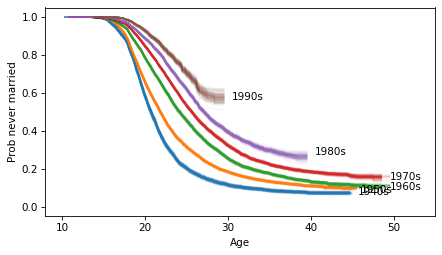

In [175]:
colors = [f"C{i}" for i in range(len(cohorts))]

for cohort, color in zip(cohorts, colors):
    plot_cohort(surv_maps, cohort, color)

xlim = [8, 55]
decorate(xlabel="Age", ylabel="Prob never married", xlim=xlim, ylim=ylim)

This visualization is good enough for exploration, but the lines look blurry and some of the labels overlap.
More work might be needed to make a publication-ready figure, but we'll keep it simple for now.

Several patterns are visible:

-   Women born in the 1940s married earliest -- cohorts born in the 1950s and 1960s married later, but about the same fraction stayed unmarried.

-   Women born in the 1970s married later *and* stayed unmarried at higher rates than previous cohorts.

-   Cohorts born in the 1980s and 1990s are marrying even later, and are on track to stay unmarried at even higher rates -- although these patterns could change in the future.

We'll have to wait for the next data release from the NSFG to learn more.

## Expected Remaining Lifetime

Given a distribution, we can compute the expected remaining lifetime as a function of elapsed time.
For example, given the distribution of pregnancy lengths, we can compute the expected time until delivery.
To demonstrate, we'll use pregnancy data from the NSFG.

The following cells download the data files and install `statadict`, which we need to read the data.

In [176]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

In [177]:
try:
    import statadict
except ImportError:
    %pip install statadict

We'll use `get_nsfg_groups` to read the data and divide it into first babies and others.

In [178]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

We'll start with a single resampling of the data.

In [179]:
sample = resample_rows_weighted(live, "finalwgt")

Here's the PMF of pregnancy durations.

In [180]:
pmf_durations = Pmf.from_seq(sample["prglngth"])

Now suppose it's the beginning of the 36th week of pregnancy.
Remembering that the most common pregnancy length is 39 weeks, we expect the remaining time to be 3-4 weeks.
To make that estimate more precise, we can identify the values in the distribution that equal or exceed 36 weeks.

In [181]:
t = 36
is_remaining = pmf_durations.qs >= t

Next we'll make a new `Pmf` object that contains only those values, shifted left so the current time is at 0.

In [182]:
ps = pmf_durations.ps[is_remaining]
qs = pmf_durations.qs[is_remaining] - t

pmf_remaining = Pmf(ps, qs)

Because we selected a subset of the values in the `Pmf`, the probabilities no longer add up to 1, but we can normalize the `Pmf` so they do.

In [183]:
pmf_remaining.normalize()

np.float64(0.9155006558810669)

Here's the result, which shows the distribution of remaining time at the beginning of the 36th week.

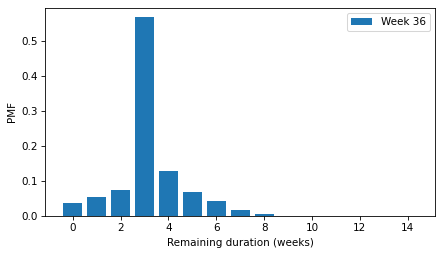

In [184]:
pmf_remaining.bar(label="Week 36")
decorate(xlabel="Remaining duration (weeks)", ylabel="PMF")

The mean of this distribution is the expected remaining time.

In [185]:
pmf_remaining.mean()

np.float64(3.2145671641791043)

The following function encapsulates these steps and computes the distribution of remaining time for a given `Pmf` at a given time, `t`.

In [186]:
def compute_pmf_remaining(pmf, t):
    """Distribution of remaining time."""
    is_remaining = pmf.qs >= t
    ps = pmf.ps[is_remaining]
    qs = pmf.qs[is_remaining] - t
    pmf_remaining = Pmf(ps, qs)
    pmf_remaining.normalize()
    return pmf_remaining

The following function takes a `Pmf` of pregnancy lengths and computes the expected remaining time at the beginning of each week from the 36th to the 43rd.

In [187]:
def expected_remaining(pmf):
    index = range(36, 44)
    expected = pd.Series(index=index)

    for t in index:
        pmf_remaining = compute_pmf_remaining(pmf, t)
        expected[t] = pmf_remaining.mean()

    return expected

Here are the results for a single resampling of the data.

In [188]:
expected = expected_remaining(pmf_durations)
expected

,0
36,3.214567
37,2.337714
38,1.479095
39,0.610133
40,0.912517
41,0.784211
42,0.582301
43,0.589372


To see how much variation there is due to random sampling, we can run this analysis with several resamplings and plot the results.

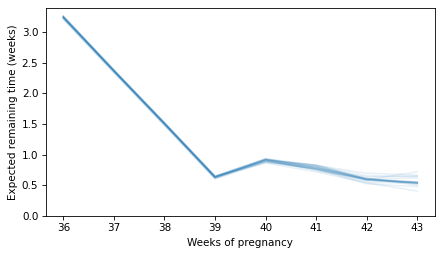

In [189]:
for i in range(21):
    sample = resample_rows_weighted(live, "finalwgt")
    pmf_durations = Pmf.from_seq(sample["prglngth"])
    expected = expected_remaining(pmf_durations)
    expected.plot(color="C0", alpha=0.1)

decorate(
    xlabel="Weeks of pregnancy", ylabel="Expected remaining time (weeks)", ylim=[0, 3.4]
)

Between weeks 36 and 39, the expected remaining time decreases until, at the beginning of the 39th week, it is about 0.6 weeks.
But after that, the curve levels off.
At the beginning of the 40th week, the expected remaining time is still close to 0.6 weeks -- actually a little higher -- and at the beginning of the 41st, 42nd, and 43rd, it is almost the same.
For people waiting anxiously for a baby to be born, this behavior seems quite cruel.

## Glossary

-   **survival analysis**: A set of methods for describing and predicting the time until an event of interest, often focused on lifetimes or durations.

-   **survival function**: A function that maps from a time, $t$, to the probability of surviving beyond $t$.

-   **hazard function**: A function that maps from $t$ to the fraction of cases that experience the event at $t$, out of all cases that survive until $t$ .

-   **cumulative hazard function**: The cumulative sum of the hazard function, often useful for visualization.

-   **weighted bootstrap:** A form of resampling that uses sampling weights to correct for stratified sampling by simulating a representative sample.

-   **censored data**: Data that is only partially known because the event of interest has not yet occurred or was unobserved.

-   **Kaplan-Meier estimation**: A method for estimating survival and hazard functions in datasets with censored observations.

-   **cohort**: A set of subjects with shared characteristics -- like decade of birth -- analyzed as a group.

## Exercises

### Exercise 13.1

We can use the methods in this chapter to estimate hazard and survival functions for the duration of a marriage.
To keep things simple, we'll consider only first marriages, and we'll focus on divorce as the endpoint, rather than separation or death.

In the NSFG data, the `cmdivorcx` column contains the date of divorce for each respondent's first marriage, if applicable, encoded in century-months.
Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing.

* For complete cases, compute the elapsed time between `cmdivorcx` and `cmmarrhx`. If both values are valid -- not `NaN` -- that means the respondent's first marriage ended in divorce.

* To identify ongoing cases, select people who have only married once and who are still married. You can use `fmarno`, which records the number of times each respondent has married, and `fmarital`, which encodes their marital status -- the value 1 indicates that the respondent is married.

In some cases the values of these variables are only approximate, so you might find a small number of negative differences, but they should not be more than one year.

Estimate the hazard and survival functions for the duration of marriage.
Plot the cumulative hazard function -- when is the danger of divorce highest?
Plot the survival function -- what fraction of marriages end in divorce?

In [190]:
# I suggest you use a single resampling of the data

sample = resample_cycles(resp)

In [210]:
# add a dur_marg column to sample dataframe of cmdivorcx minus cmmarrhx, where
# cmdivorcx is not NaN.
sample["dur_marriage"] = sample["cmdivorcx"] - sample["cmmarrhx"]
#display columns dur_marraige, fmarno, and fmarital from sample
sample[["dur_marriage", "fmarno", "fmarital", "age"]]

,dur_marriage,fmarno,fmarital,age
69207,29.0,2.0,1.0,29.833333
65596,NaN,1.0,1.0,34.416667
64695,NaN,0.0,6.0,19.416667
69386,NaN,0.0,6.0,16.583333
64810,24.0,2.0,1.0,33.833333
...,...,...,...,...
5261,36.0,1.0,NaN,35.500000
343,NaN,1.0,NaN,37.500000
3363,NaN,0.0,NaN,26.500000
1665,NaN,1.0,NaN,31.500000


In [290]:
# divorced cases
completem = sample.query("dur_marriage.isna()")["age"]
completem.count()


np.int64(60176)

In [291]:
#  ongoing cases, select people who have only married once and who are still married
ongoingm = sample.query("fmarno == 1  & fmarital == 1")["age"]
ongoingm.count()

np.int64(3534)

In [292]:
# Freq Tab and Survival  of both
ft_completem = FreqTab.from_seq(completem)
ft_ongoingm = FreqTab.from_seq(ongoingm)

surv_completem= ft_completem.make_surv()
surv_ongoingm = ft_ongoingm.make_surv()

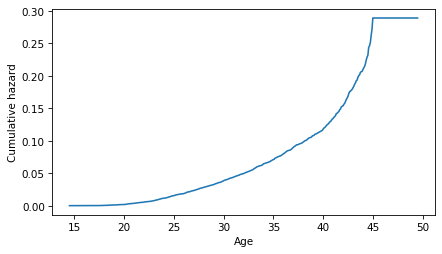

In [299]:
# all cohorts and at risk
tsm = pd.Index.union(ft_completem.index, ft_ongoingm.index)
at_riskm = ft_completem(tsm) + ft_ongoingm(tsm) + surv_completem(tsm) + surv_ongoingm(tsm)

# Cumulative Hazard and plot.  danger of divoce, anytime after 45 y.o.
hsm = ft_ongoingm(tsm) / at_riskm
hazard = Hazard(hsm, tsm)

hazard.cumsum().plot()
decorate(xlabel="Age", ylabel="Cumulative hazard")

In [306]:
 # When is the danger of divorce highest?  45 y.o. from this dataset
 hazard.cumsum().idxmax()


np.float64(45.0)

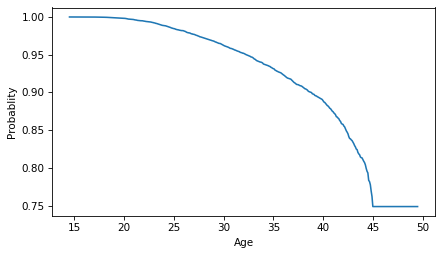

In [300]:
# Survival Plot.
survm = hazard.make_surv()
survm.plot()
decorate(xlabel="Age", ylabel="Probablity")

In [302]:
# What percentage of marriages end in divorce? 755 from this dataset.
survm.iloc[-1] * 100

np.float64(74.89528413724102)

In [199]:
# Solution goes here

### Exercise 13.2

In 2012, a team of demographers at the University of Southern California estimated life expectancy for people born in Sweden in the early 1800s and 1900s.
For ages from 0 to 91 years, they estimated the age-specific mortality rate, which is the fraction of people who die at a given age, out of all who survive until that age -- which you might recognize as the hazard function.

I used an online graph digitizer to get the data from the figure in their paper and store it in a CSV file.
Instructions for downloading the data are in the notebook for this chapter.

Data source: Beltrán-Sánchez, H., Crimmins, E. M., & Finch, C. E. (2012). Early cohort mortality predicts the rate of aging in the cohort: a historical analysis. *Journal of developmental origins of health and disease*, 3(5), 380-386.

The following cell downloads the data.

In [200]:
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/mortality_rates_beltran2012.csv"
)

We can load the data like this.

In [201]:
mortality = pd.read_csv("mortality_rates_beltran2012.csv", header=[0, 1]).dropna()

The following function interpolates the data to make a hazard function with approximate mortality rates for each age from 0 to 99.

In [202]:
from scipy.interpolate import interp1d
from empiricaldist import Hazard


def make_hazard(ages, rates):
    """Make a Hazard function by interpolating a Series.

    series: Series

    returns: Hazard
    """
    interp = interp1d(ages, rates, fill_value="extrapolate")
    xs = np.arange(0, 100)
    ys = np.exp(interp(xs))
    return Hazard(ys, xs)

Now we can make a `Hazard` object like this.

In [203]:
ages = mortality["1800", "X"].values
rates = mortality["1800", "Y"].values
hazard = make_hazard(ages, rates)

Here's what the mortality rates look like.

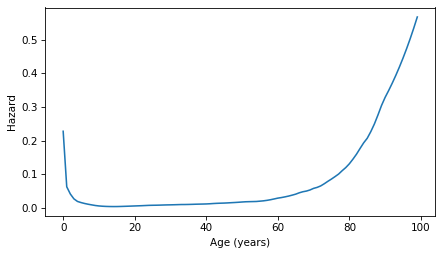

In [204]:
hazard.plot()

decorate(xlabel="Age (years)", ylabel="Hazard")

Use `make_surv` to make a survival function based on these rates, and `make_cdf` to compute the corresponding CDF.
Plot the results.

Then use `make_pmf` to make a `Pmf` object that represents the distribution of lifetimes, and plot it.
Finally, use `compute_pmf_remaining` to compute the average remaining lifetime at each age from 0 to 99.
Plot the result.

In the remaining lifetime curve, you should see a counterintuitive pattern -- for the first few years of life, remaining lifetime increases.
Because infant mortality was so high in the early 1800s, an older child was expected to live longer than a younger child.
After about age 5, life expectancy returns to the pattern we expect -- young people are expected to live longer than old people.

If you are interested in this topic, you might like Chapter 5 of my book, *Probably Overthinking It*, which presents similarly counterintuitive results from many areas of statistics.

Available from <https://probablyoverthinking.it>.

In [205]:
# Solution goes here

In [206]:
# Solution goes here

In [207]:
# Solution goes here

In [208]:
# Solution goes here

In [209]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)